# Face Generation


In [2]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Visualize the CelebA Data


In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform_img = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        ])
    train_data = datasets.ImageFolder(root=data_dir, transform=transform_img)
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

In [6]:
# Define function hyperparameters
batch_size = 128
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)


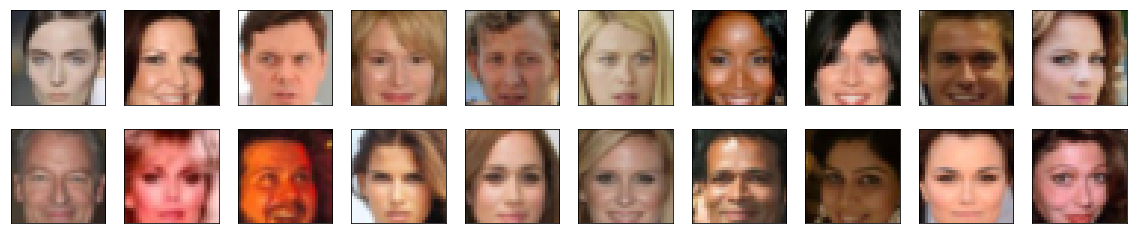

In [7]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process image data and scale it to a pixel range of -1 to 1


In [8]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x * (max(feature_range) - min(feature_range)) + min(feature_range)
    return x

In [9]:
# check scaled range
# should be close to -1 to 1
img = images[3]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9294)
Max:  tensor(0.8588)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
def conv2_bn(in_channels, out_channels, kernel_size, stride, padding, is_batch_norm=True):
    layers = []
    layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
        stride=stride, padding=padding, bias=False))
    if is_batch_norm:
        layers.append(nn.BatchNorm2d(num_features=out_channels))
    return nn.Sequential(*layers)

In [13]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv2_bn(3, self.conv_dim, 4, 2, 1, False)
        self.conv2 = conv2_bn(self.conv_dim, conv_dim*2, 4, 2, 1, True)
        self.conv3 = conv2_bn(self.conv_dim*2, conv_dim*4, 4, 2, 1, True)
        self.fc = nn.Linear(self.conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2) # set to 0.2 as mentioned in the paper
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        # Flatten the input
        out = x.view(-1, self.conv_dim*4*4*4)
        out = self.fc(out)
        return out

## Generator

The generator should upsample an input and generate a *new* image of the same size as  training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [14]:
def deconv2d_bn(in_channels, out_channels, kernel_size, stride, padding, is_batch_norm):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
        stride=stride, padding=padding, bias=False))
    if is_batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return(nn.Sequential(*layers))

In [15]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # initate variables
        self.z_size = z_size
        self.conv_dim = conv_dim
    
        self.fc = nn.Linear(self.z_size, self.conv_dim*4*4*4) 
        self.conv1 = deconv2d_bn(self.conv_dim*4, self.conv_dim*2, 4, 2, 1, True)
        self.conv2 = deconv2d_bn(self.conv_dim*2, self.conv_dim, 4, 2, 1, True)
        self.conv3 = deconv2d_bn(self.conv_dim, 3, 4, 2, 1, True)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        out = self.conv3(x)
        out = F.tanh(out)
        return out

## Initialize the weights of your networks

From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.


* This should initialize only **convolutional** and **linear** layers

In [16]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    if(hasattr(m, 'weight')):

        classname = m.__class__.__name__
        if(classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal(m.weight.data, 0.0, 0.02)

## Build complete network

In [17]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Define model hyperparameters

In [19]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 128
z_size = 256

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=256, out_features=8192, bias=True)
  (conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), b

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  from ipykernel import kernelapp as app


### Training on GPU

>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [20]:
import torch

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses


### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. .


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.


In [21]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    labels = torch.ones(D_out.size(0))
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    labels = torch.zeros(D_out.size(0))
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Define optimizers for your models with appropriate hyperparameters.

In [22]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), 0.0002, [0.5, 0.999])
g_optimizer = optim.Adam(G.parameters(), 0.0002, [0.5, 0.999])

---
## Training

Training will involve alternating between training the discriminator and the generator.

In [23]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            
            d_optimizer.zero_grad()
            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()
            d_output_real = D(real_images)
            d_output_fake = D(G(fixed_z))
            d_loss = real_loss(d_output_real) + fake_loss(d_output_fake)
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            g_output_fake = D(G(fixed_z))
            g_loss = real_loss(g_output_fake)
            g_loss.backward()
            g_optimizer.step()
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set number of training epochs and train your GAN!

In [96]:
# set number of epochs 
n_epochs = 25

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 1.2132 | g_loss: 1.4308
Epoch [    1/   25] | d_loss: 0.3398 | g_loss: 2.1289
Epoch [    1/   25] | d_loss: 0.2461 | g_loss: 2.2389
Epoch [    1/   25] | d_loss: 0.4251 | g_loss: 1.8436
Epoch [    1/   25] | d_loss: 0.1455 | g_loss: 2.7488
Epoch [    1/   25] | d_loss: 0.1185 | g_loss: 2.7326
Epoch [    1/   25] | d_loss: 0.2284 | g_loss: 2.9360
Epoch [    1/   25] | d_loss: 0.4086 | g_loss: 2.9486
Epoch [    1/   25] | d_loss: 0.4647 | g_loss: 1.1344
Epoch [    1/   25] | d_loss: 0.0965 | g_loss: 3.3339
Epoch [    1/   25] | d_loss: 0.0810 | g_loss: 3.5487
Epoch [    1/   25] | d_loss: 0.0579 | g_loss: 3.7381
Epoch [    1/   25] | d_loss: 0.0474 | g_loss: 3.7700
Epoch [    1/   25] | d_loss: 0.2269 | g_loss: 2.9481
Epoch [    1/   25] | d_loss: 0.0750 | g_loss: 3.7896
Epoch [    2/   25] | d_loss: 0.0452 | g_loss: 3.9316
Epoch [    2/   25] | d_loss: 0.1098 | g_loss: 2.7280
Epoch [    2/   25] | d_loss: 0.2086 | g_loss: 2.9732
Epoch [    2/   25] | d_loss

Epoch [   11/   25] | d_loss: 0.2806 | g_loss: 3.1672
Epoch [   11/   25] | d_loss: 0.1174 | g_loss: 3.4086
Epoch [   11/   25] | d_loss: 0.4910 | g_loss: 3.3885
Epoch [   11/   25] | d_loss: 0.3107 | g_loss: 2.4572
Epoch [   11/   25] | d_loss: 0.4562 | g_loss: 2.2294
Epoch [   11/   25] | d_loss: 0.3535 | g_loss: 3.7905
Epoch [   11/   25] | d_loss: 0.3425 | g_loss: 2.4255
Epoch [   11/   25] | d_loss: 0.2439 | g_loss: 3.5058
Epoch [   11/   25] | d_loss: 0.7100 | g_loss: 1.5242
Epoch [   11/   25] | d_loss: 0.2875 | g_loss: 2.8064
Epoch [   11/   25] | d_loss: 0.0820 | g_loss: 3.2541
Epoch [   11/   25] | d_loss: 1.4144 | g_loss: 1.7755
Epoch [   11/   25] | d_loss: 0.1801 | g_loss: 3.0950
Epoch [   12/   25] | d_loss: 0.3193 | g_loss: 2.4645
Epoch [   12/   25] | d_loss: 0.1600 | g_loss: 3.4363
Epoch [   12/   25] | d_loss: 0.3240 | g_loss: 2.2034
Epoch [   12/   25] | d_loss: 0.6436 | g_loss: 1.7651
Epoch [   12/   25] | d_loss: 0.4443 | g_loss: 2.6391
Epoch [   12/   25] | d_loss

Epoch [   21/   25] | d_loss: 0.0629 | g_loss: 4.0192
Epoch [   21/   25] | d_loss: 0.5005 | g_loss: 2.8132
Epoch [   21/   25] | d_loss: 0.0482 | g_loss: 4.0936
Epoch [   21/   25] | d_loss: 0.0531 | g_loss: 3.8862
Epoch [   21/   25] | d_loss: 0.1103 | g_loss: 3.4837
Epoch [   21/   25] | d_loss: 0.0148 | g_loss: 4.7263
Epoch [   21/   25] | d_loss: 0.0358 | g_loss: 4.2898
Epoch [   21/   25] | d_loss: 0.0372 | g_loss: 3.7990
Epoch [   21/   25] | d_loss: 0.1150 | g_loss: 3.3479
Epoch [   21/   25] | d_loss: 0.2298 | g_loss: 2.5124
Epoch [   21/   25] | d_loss: 0.0569 | g_loss: 3.9782
Epoch [   22/   25] | d_loss: 0.0755 | g_loss: 4.2106
Epoch [   22/   25] | d_loss: 0.0588 | g_loss: 3.3450
Epoch [   22/   25] | d_loss: 0.1367 | g_loss: 3.3984
Epoch [   22/   25] | d_loss: 0.1797 | g_loss: 3.6089
Epoch [   22/   25] | d_loss: 0.0349 | g_loss: 4.2103
Epoch [   22/   25] | d_loss: 0.0686 | g_loss: 3.8928
Epoch [   22/   25] | d_loss: 0.0700 | g_loss: 5.0502
Epoch [   22/   25] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

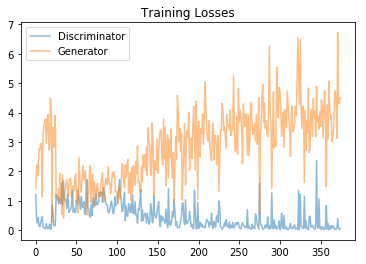

In [98]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [99]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [100]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

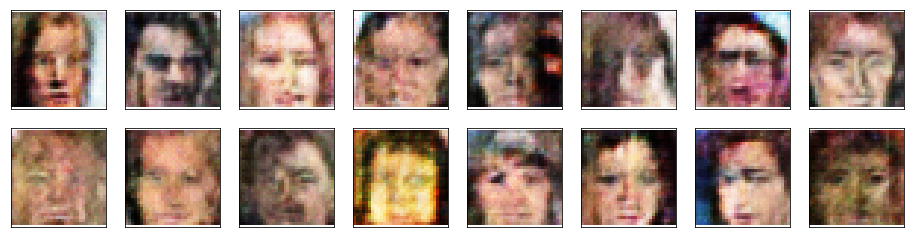

In [101]:
_ = view_samples(-1, samples)